When a medical claim is submitted, the insurance provider must process the claim to determine the correct financial responsibility of the insurance provider and the patient. The process to determine this is broadly known as claims adjudication. It involves creating a claims processing workflow that checks each claim for authenticity, correctness, and validity based on coverage. Some of the steps in this workflow involve working with unstructured data (data that is not represented as rows and columns) which requires manual steps in the workflow to extract the information buried in the unstructured notes. According to the 2018 CAHQ index report, there were approximately 6.1 billion medical claims submitted in 2018, which represents a 4 percent increase in the volume from 2017, and it’s expected to continue rising in subsequent years. To process such volumes in a cost effective and scalable manner, healthcare payers are increasingly looking at machine learning to reduce dependency on humans and rely on automation as much as possible. Additionally, analyzing and interpreting health claim data is powerful in driving improvements in population health to address issues related to cost, quality and outcomes. According to the CDC report analyzing claim documents will help identify certain behaviors that would help in preventing or delaying the development of a medical condition. Healthcare is a data intense industry, and customers are looking for ways to automate and analyze these data.

In [1]:
import boto3
import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [2]:
!pip install amazon-textract-response-parser

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
role = get_execution_role()
#print("RoleArn: {}".format(role))

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'claims-process-textract'

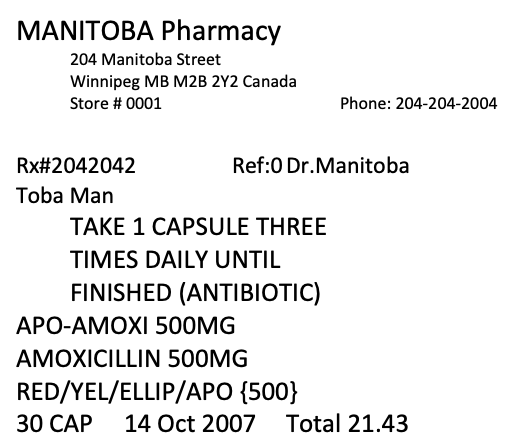

In [5]:


from IPython.display import Image
image_filename = "Prescription-sample.png"
Image(filename=image_filename)



In [6]:


!python -m pip install -q boto3
import boto3
import json

#create a Textract Client
textract = boto3.client('textract')
# Document
documentName = image_filename



You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [7]:

response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = textract.analyze_document(
        Document={'Bytes': imageBytes},
        # new QUERIES Feature Type for Textract Queries
        # We could add additional Feature Types like FORMS and/or TABLES
        # FeatureTypes=["QUERIES", "FORMS", "TABLS"],
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the name of the pharmacy?",
                "Alias": "PHARMACY_NAME"
            },
            {
                "Text": "What is the address of the pharmacy?",
                "Alias": "PHARMACY_ADDRESS"
            },
            {
                "Text": "What is the store number of the pharmacy",
                "Alias": "PHARMACY_STORE_NUM"
            },
            {
                "Text": "What is the phone number of the pharmacy?",
                "Alias": "PHARMACY_PHONE_NUM"
            },
            {
                "Text": "What is the prescription number?",
                "Alias": "PRESCRIPTION_NUM"
            },
            {
                "Text": "What is the physician name?",
                "Alias": "DOCTOR_NAME"
            },
            {
                "Text": "What is the date that the prescription was filled?",
                "Alias": "PRESCRIPTION_DATE"
            },
            {
                "Text": "What is the name of the person for whom the drug is prescribed?",
                "Alias": "PATIENT_NAME"
            },
            {
                "Text": "What is the name of the medication or the main ingredient?",
                "Alias": "MEDICATION"
            },
            {
                "Text": "What is the strength of the medication?",
                "Alias": "DOASAGE"
            },
            {
                "Text": "What is the direction to take the medication?",
                "Alias": "MEDICATION_DIRECTION"
            }
    ]
        })
    print(response)

{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 4.4129970433459675e-07}, {'X': 1.0, 'Y': 0.0}, {'X': 1.0, 'Y': 1.0}, {'X': 5.016706381866243e-06, 'Y': 1.0}]}, 'Id': '37644bf7-4b22-4bed-94eb-7b0f858819b7', 'Relationships': [{'Type': 'CHILD', 'Ids': ['1ac65c91-6bcd-4de6-829c-66e5beefb377', 'a49b8f37-0e79-4352-afa2-6ba7b5fa152a', '71e32700-b76b-4d67-9267-fca371b6b52e', '148e90fa-3f5f-4262-9497-c7c3796e855a', '8ff4e229-1ee7-4fe4-80a9-c786043ca9be', '00567400-9d17-47e5-adfe-6f83e50b03ce', '165565c0-aaf2-42f2-b323-7f021ce0f6e6', 'ebb04c62-aa03-4536-9020-493ee463258c', '80a0d682-ea03-4401-9f7d-62b0b98bbe2b', 'b94a07bf-4d67-4816-9c4b-6d134a6cbff2', '6e06e0b9-cd7b-4bdd-935c-a6b3082ff1c0', '75d8d7d6-e521-485c-8863-33feccd1cadd', '1b1f405a-ca08-4c78-8440-4219fa8d6e14', 'c2348c20-eadb-45da-8306-9c882262fcf4', '07058590-26e2-4c3a-a189-c85cada70444', '97f102f4-eba8-4bcb

### EXERCISE-2

# Sample Document

30 fields. 2 fileds are optional [ local use, xxx]
member id field is a mandatory field

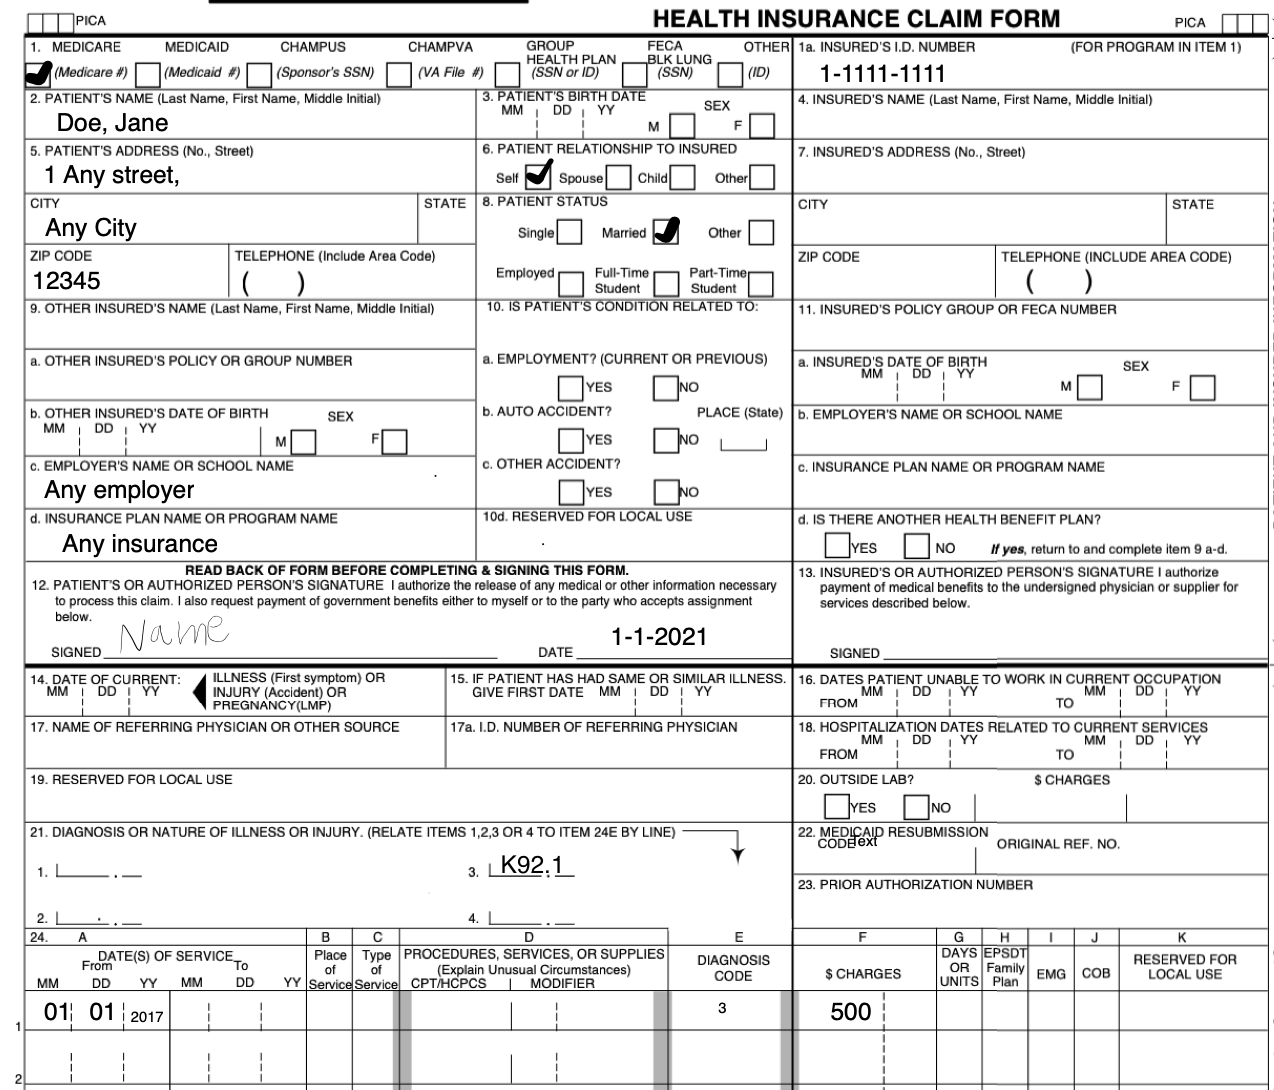

In [8]:
# Document

documentName = "cms1500-1.png"

display(Image(filename=documentName))

# Data Extraction

In [9]:
# process using image bytes
def calltextract(documentName): 
    client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [10]:
response= calltextract(documentName)
print(response)

Image loaded cms1500-1.png
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 3.1591906690664473e-07, 'Y': 0.0}, {'X': 1.0, 'Y': 4.2800297705980483e-07}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0, 'Y': 1.0}]}, 'Id': '5286d57b-f40d-4f72-a928-c414072b8aa5', 'Relationships': [{'Type': 'CHILD', 'Ids': ['e141d065-a267-4dd2-9e31-626e7e69ff12', '1fe16332-af81-4790-b8aa-59b23de0067c', '2c71f9b6-d0dc-49f4-8f4b-f131e3a608f2', 'efae2335-6683-4418-9e14-d82d42f7bc64', '6771fc98-e99f-48f5-abbc-dba54e074464', '3a80df92-b026-43d7-90d9-521cf58abfba', '552dfc88-f9b6-415f-aa63-4a8a55904594', '57c68e25-9024-46c6-a84f-3465244e6a8c', '9fe56033-382c-4b2e-94f1-56a6b1a1b95c', 'bb76838b-9051-46eb-9443-929c0b415700', '52d8218c-8b37-4ac4-b7cb-98ee3d662cc5', 'a4f2702b-4fc5-4c2f-8591-b3c8f197ec8d', '4fd9948d-e17b-4015-9d77-8cec103cbffa', 'aeaac50d-4f99-4351-8bd9-d3e4414edc98', '738eb437-9bae-4d87-b1fa-cc8b55

In [11]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

In [12]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'ZIP CODE': '12345', '(ID)': 'NOT_SELECTED', 'NO': 'NOT_SELECTED', 'TELEPHONE (Include Area Code)': '( )', 'Single': 'NOT_SELECTED', 'CITY': 'Any City', 'Employed': 'NOT_SELECTED', 'Self': 'SELECTED', 'YES': 'NOT_SELECTED', 'Full-Time Student': 'NOT_SELECTED', 'Other': 'NOT_SELECTED', 'Married': 'SELECTED', 'DATE': '1-1-2021', "2. PATIENT'S NAME (Last Name, First Name, Middle Initial)": 'Doe, Jane', 'FECA BLK LUNG (SSN)': 'NOT_SELECTED', "5. PATIENT'S ADDRESS (No., Street)": '1 Any street,', 'd. INSURANCE PLAN NAME OR PROGRAM NAME': 'Any insurance', "c. EMPLOYER'S NAME OR SCHOOL NAME": 'Any employer', 'TELEPHONE (INCLUDE AREA CODE)': '( )', 'SIGNED': 'Name', 'F': 'NOT_SELECTED', 'M': 'NOT_SELECTED', 'Part-Time Student': 'NOT_SELECTED', '3.': 'K92.1', 'Child': 'NOT_SELECTED', '(Medicare #)': 'SELECTED', "CHAMPUS (Sponsor's SSN)": 'NOT_SELECTED', "1a. INSURED'S I.D. NUMBER (FOR PROGRAM IN ITEM 1)": '1-1111-1111', 'CHAMPVA': 'NOT_SELECTED', 'PICA': 'NOT_SELECTED', 'MEDICAID': 'NOT_SELECT

# Enrich with medical insights
Valid Medical Intake Form send to Comprehend medical to gain insights

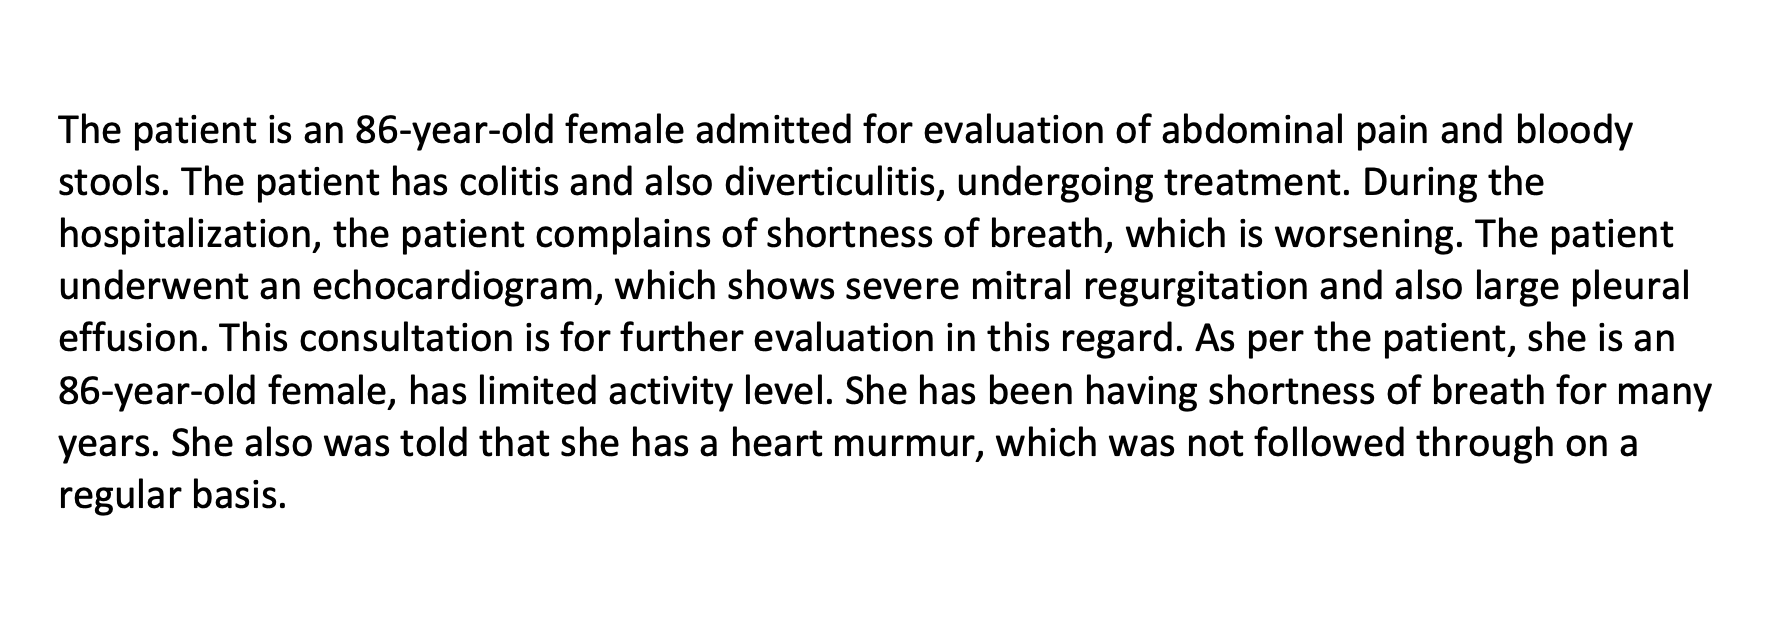

In [14]:
documentName = "doctornotes1.png"
display(Image(filename=documentName))



In [15]:
response= calltextract(documentName)
# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

Image loaded doctornotes1.png

Text
The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody
stools. The patient has colitis and also diverticulitis, undergoing treatment. During the
hospitalization, the patient complains of shortness of breath, which is worsening. The patient
underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural
effusion. This consultation is for further evaluation in this regard. As per the patient, she is an
86-year-old female, has limited activity level. She has been having shortness of breath for many
years. She also was told that she has a heart murmur, which was not followed through on a
regular basis.



## Get Medical Insights

In [16]:
comprehend = boto3.client(service_name='comprehendmedical')
# Detect medical entities

cm_json_data =  comprehend.detect_entities_v2(Text=text)

print("\nMedical Entities\n========")
for entity in cm_json_data["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")


Medical Entities
- 86
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- evaluation
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- abdominal
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- pain
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- bloody stools
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- colitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- diverticulitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- treatment
   Type: TREATMENT_NAME
   Category: TEST_TREATMENT_PROCEDURE


- shortness of breath
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- echocardiogram
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- mitral
   Type: SYSTEM_ORGAN_SITE
   Category: ANATOMY


- mitral regurgitation
   Type: DX_NAME
   Category: MEDICAL_CONDITION


- pleural
   Type: SYSTEM_ORGAN_SITE
   Category: A

In [29]:
cm_json_data =  comprehend.infer_icd10_cm(Text=text)

print("\n Medical coding\n========")
code = []

for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        
        if (icd["Score"] >= 0.90):
            code.append(icd["Code"])
            
print(code)



 Medical coding
['K92.1', 'R06.02', 'J90', 'R06.02', 'R01.1']


In [22]:
def validate(body):
    json_acceptable_string = body.replace("'", "\"")
    
    json_data = json.loads(body)
    
    zip = json_data['ZIP CODE']
    
    id = json_data['1a. INSURED\'S I.D. NUMBER (FOR PROGRAM IN ITEM 1)']
    
    diagnosiscode = json_data["3."]
    print(diagnosiscode)
    print(id)
    print(zip)
    if(not zip.strip().isdigit()):
        return False, id, diagnosiscode, "Zip code invalid"
    length = len(id.strip())
    if(length != 11):
        return False, id, diagnosiscode, "Invalid claim Id"
    return True, id, diagnosiscode, "Ok"

In [23]:
 # Validate 
documentName = "cms1500-1.png"
response= calltextract(documentName)
get_form_keys = getformkeyvalue(response)

textract_json= json.dumps(get_form_keys,indent=2)
print(textract_json)
res, formid, diagnosiscode, result = validate(textract_json)
print(result)
print(formid)

Image loaded cms1500-1.png
{
  "ZIP CODE": "12345",
  "(ID)": "NOT_SELECTED",
  "NO": "NOT_SELECTED",
  "TELEPHONE (Include Area Code)": "( )",
  "Single": "NOT_SELECTED",
  "CITY": "Any City",
  "Employed": "NOT_SELECTED",
  "Self": "SELECTED",
  "YES": "NOT_SELECTED",
  "Full-Time Student": "NOT_SELECTED",
  "Other": "NOT_SELECTED",
  "Married": "SELECTED",
  "DATE": "1-1-2021",
  "2. PATIENT'S NAME (Last Name, First Name, Middle Initial)": "Doe, Jane",
  "FECA BLK LUNG (SSN)": "NOT_SELECTED",
  "5. PATIENT'S ADDRESS (No., Street)": "1 Any street,",
  "d. INSURANCE PLAN NAME OR PROGRAM NAME": "Any insurance",
  "c. EMPLOYER'S NAME OR SCHOOL NAME": "Any employer",
  "TELEPHONE (INCLUDE AREA CODE)": "( )",
  "SIGNED": "Name",
  "F": "NOT_SELECTED",
  "M": "NOT_SELECTED",
  "Part-Time Student": "NOT_SELECTED",
  "3.": "K92.1",
  "Child": "NOT_SELECTED",
  "(Medicare #)": "SELECTED",
  "CHAMPUS (Sponsor's SSN)": "NOT_SELECTED",
  "1a. INSURED'S I.D. NUMBER (FOR PROGRAM IN ITEM 1)": "1-11

## Post Processing - Compare the dignosis code from the RAW doctor's notes

In [30]:
print("diagnosis code from claim form", diagnosiscode)
print("diagnosis code from raw doctor's note", code)

diagnosis code from claim form K92.1
diagnosis code from raw doctor's note ['K92.1', 'R06.02', 'J90', 'R06.02', 'R01.1']


Writing entities to CSV File

# Invalid Claim

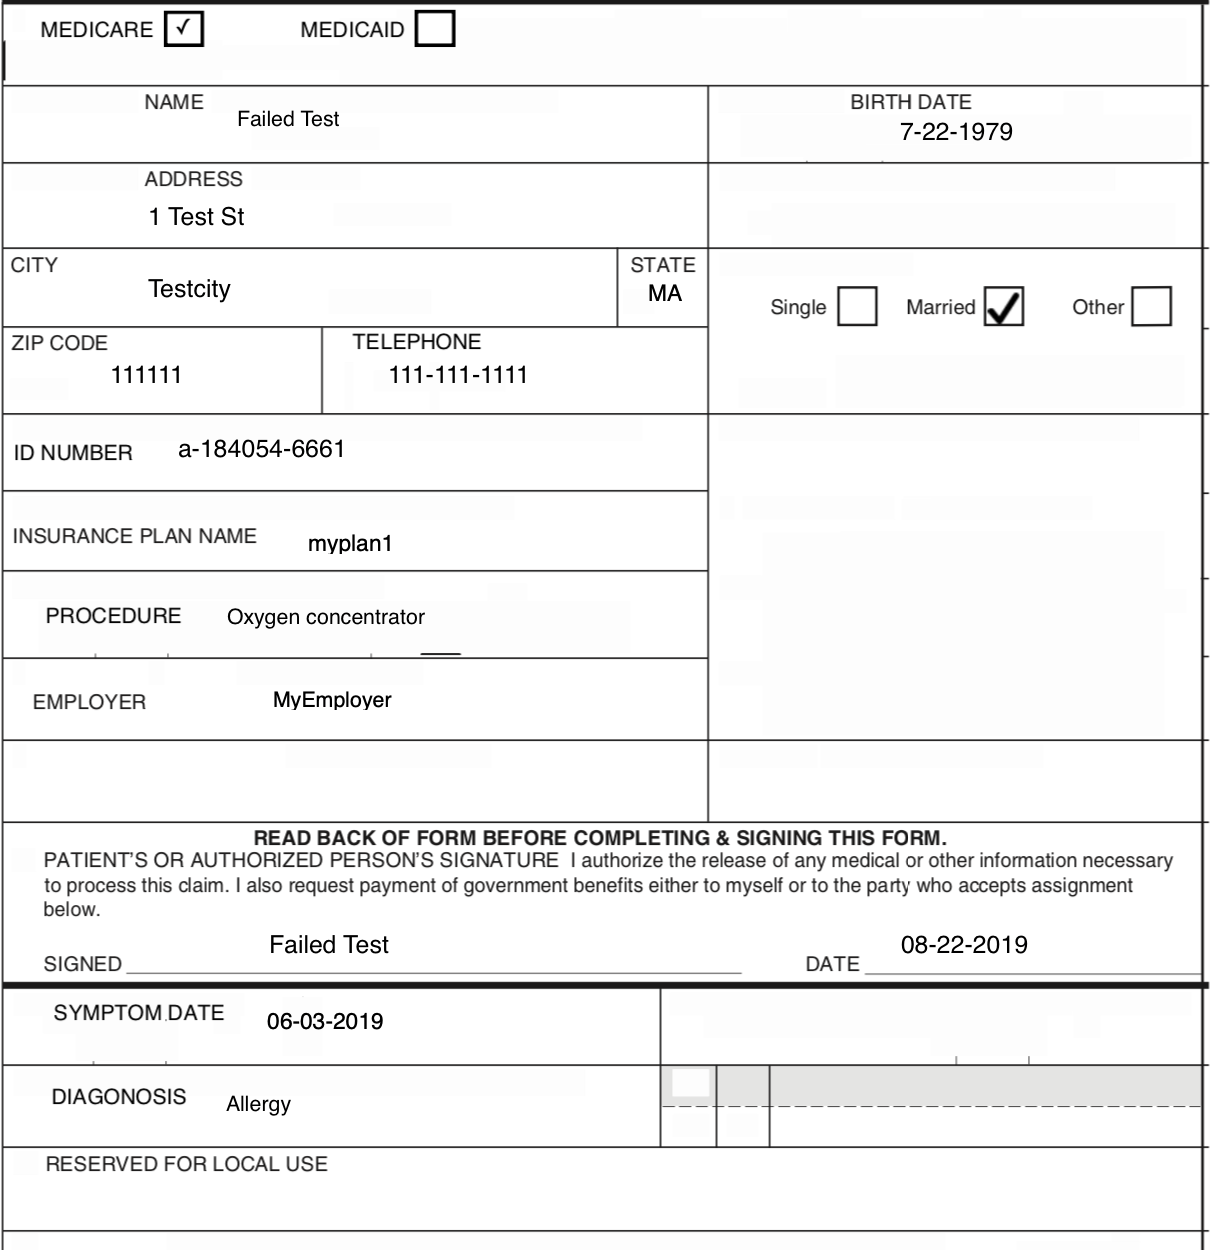

In [32]:
InvalidDocument = "failedtest.png"

display(Image(filename=InvalidDocument))

In [33]:
response = calltextract(InvalidDocument)

Image loaded failedtest.png


In [34]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'CITY': 'Testcity', 'TELEPHONE': '111-111-1111', 'DATE': '08-22-2019', 'ADDRESS': '1 Test St', 'Married': 'SELECTED', 'ZIP CODE': '111111', 'Other': 'NOT_SELECTED', 'SIGNED': 'Failed Test', 'NAME': 'Failed Test', 'MEDICAID': 'NOT_SELECTED', 'ID NUMBER': 'a-184054-6661', 'INSURANCE PLAN NAME': 'myplan1', 'BIRTH DATE': '7-22-1979', 'MEDICARE': 'SELECTED', 'SYMPTOM.DATE': '06-03-2019', 'Single': 'NOT_SELECTED', 'EMPLOYER': 'MyEmployer', 'STATE': 'MA', 'PROCEDURE': 'Oxygen concentrator', 'DIAGONOSIS': 'Allergy'}


In [35]:
 #In Validate 
textract_json= json.dumps(get_form_keys,indent=2)
json_data = json.loads(textract_json)

id = json_data['ID NUMBER']
print(id)

length = len(id.strip())
if(length != 11):
    print("Invalid claim Id")


a-184054-6661
Invalid claim Id


Delete the Amazon s3 bucket and the files in the buckethttps://docs.aws.amazon.com/AmazonS3/latest/userguide/delete-bucket.html